In [45]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [46]:
data = pd.read_csv('ANOVA data.csv')
data = data[['A','B','n','y']]
data.head()

,A,B,n,y
0,a1,b1,1,38.120639
1,a2,b1,1,55.550930
2,a1,b2,1,42.493114
3,a2,b2,1,49.785842
4,a1,b3,1,40.988523


C:\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


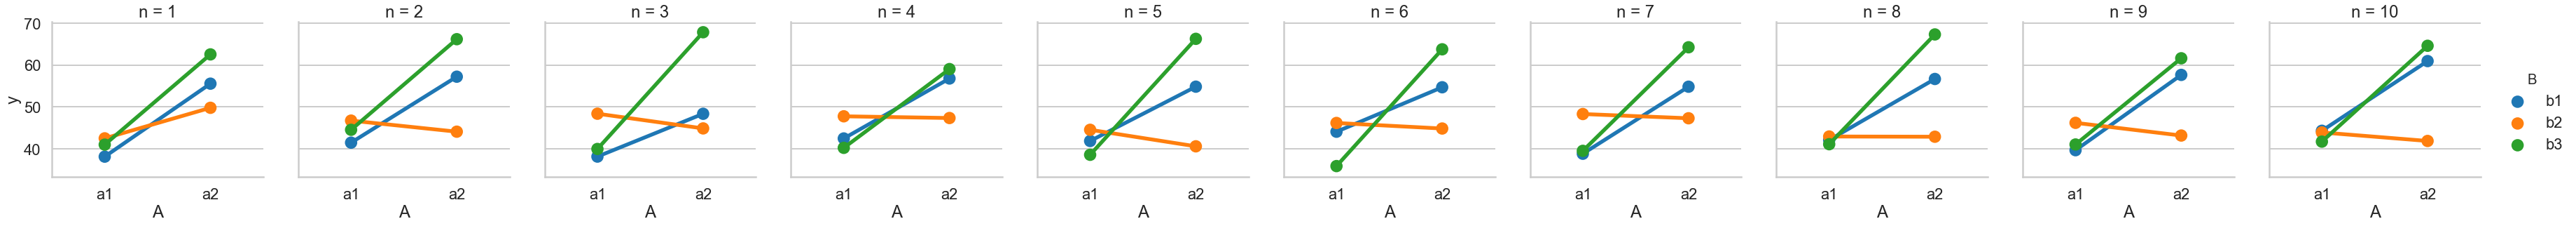

In [47]:
sns.factorplot(x='A',y='y',hue='B',data=data,col='n')

In [48]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [49]:
formula = 'y ~ C(A) + C(B) + + C(n) + C(A):C(B) + C(A):C(n) + C(B):C(n)'
model = ols(formula,data).fit()
aov_table = anova_lm(model, typ=2)
aov_table = eta_squared(aov_table)
aov_table = omega_squared(aov_table)
print(aov_table)

                sum_sq    df           F        PR(>F)    eta_sq  omega_sq
C(A)       2352.676204   1.0  397.755821  1.011150e-13  0.486960  0.485142
C(B)        510.821829   2.0   43.181113  1.350711e-07  0.105731  0.103156
C(n)         28.191531   9.0    0.529579  8.343918e-01  0.005835 -0.005177
C(A):C(B)  1603.144818   2.0  135.518050  1.408912e-11  0.331821  0.328970
C(A):C(n)    22.644237   9.0    0.425373  9.042874e-01  0.004687 -0.006324
C(B):C(n)   207.403803  18.0    1.948043  8.339085e-02  0.042929  0.020866
Residual    106.467761  18.0         NaN           NaN       NaN       NaN


# repeated 2-way ANOVA

In [50]:
df = pd.read_csv('repeated ANOVA data.csv')
df = df.drop(columns = ['scores_mean','scores_std'])

In [57]:
df.head()

,awareness_1,awareness_2,awareness_3,awareness_4,confidence_1,confidence_2,confidence_3,confidence_4,correct_1,correct_2,correct_3,correct_4,model_name,sub_name
0,0.412521,0.381744,-0.027650,-0.112417,0.683061,-0.042366,0.145254,-0.035692,0.115263,0.040309,-0.168754,0.149696,LogisticRegression,AC
1,0.393514,-0.444127,-0.678866,0.211154,2.490060,-0.403420,-0.602135,-0.190138,-0.272227,-0.382330,0.118554,-0.240039,RandomForest,AC
2,2.053481,0.252121,-0.639925,0.025580,2.357185,1.515132,0.687232,-0.038286,0.140470,0.036779,0.020269,0.364253,LogisticRegression,CL
3,1.248663,-0.474414,-0.498063,-0.483757,2.774352,0.392783,-0.319482,-0.657793,-0.592564,-0.542531,-0.443991,-0.403202,RandomForest,CL
4,-0.367196,-0.579417,0.086532,-0.215579,0.324850,0.149319,0.094679,0.300454,-0.401702,0.131648,0.189891,0.053520,LogisticRegression,FW


In [58]:
df_stats = pd.melt(df,
                   id_vars=['sub_name','model_name'],
                  )

In [59]:
df_stats.loc[df_stats['model_name'] == 'LogisticRegression','value'] = \
    df_stats[df_stats['model_name'] == 'LogisticRegression']['value'].apply(np.exp).values - 1

In [60]:
def split(variable,idx = 0):
    return variable.split('_')[idx]

In [61]:
df_stats['features'] = df_stats['variable'].apply(split,idx=0)

In [62]:
df_stats['window'] = df_stats['variable'].apply(split,idx = 1)

In [63]:
from statsmodels.stats.anova import AnovaRM

In [64]:
anorm = AnovaRM(df_stats,depvar='value',subject='sub_name',within=['features','window','model_name'],
               aggregate_func='mean')
res = anorm.fit()

In [65]:
print(res)

                         Anova
                           Num DF  Den DF F Value Pr > F
--------------------------------------------------------
features                   2.0000 28.0000  7.6538 0.0022
window                     3.0000 42.0000 20.8548 0.0000
model_name                 1.0000 14.0000 14.6427 0.0019
features:window            6.0000 84.0000  6.2704 0.0000
features:model_name        2.0000 28.0000  1.8018 0.1836
window:model_name          3.0000 42.0000  3.2210 0.0321
features:window:model_name 6.0000 84.0000  2.3000 0.0419



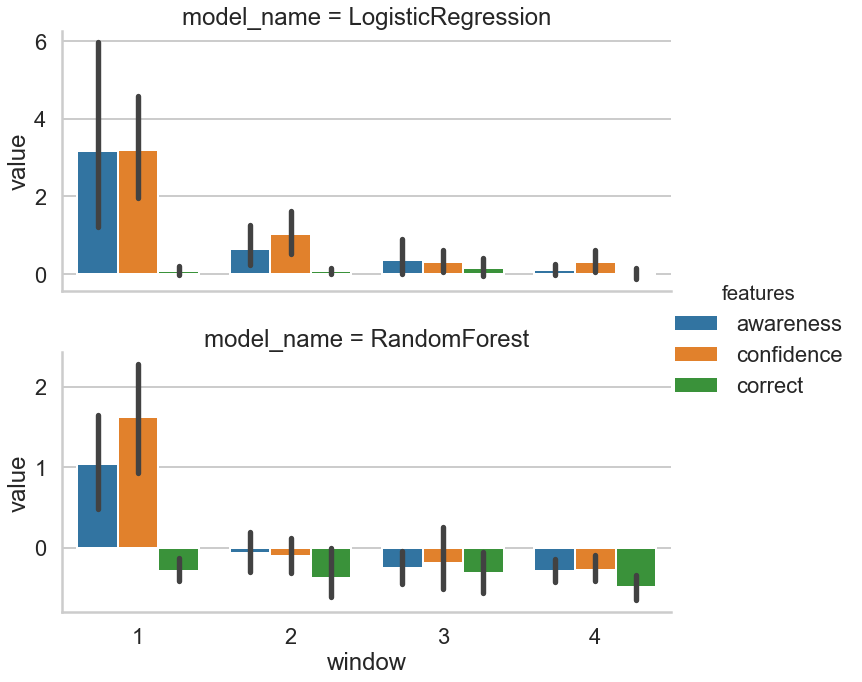

In [66]:
g = sns.catplot(x = 'window',
                y = 'value',
                hue = 'features',
                row = 'model_name',
                data = df_stats,
                kind = 'bar',
                aspect = 2,
                sharey = False,)